In [58]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from acgan import torch_gan
%matplotlib inline

In [9]:
import torch.utils.data
import torchvision.datasets as dset

import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt

import numpy as np

In [7]:
device='cpu'
dataroot = '/export/datasets/celeba'

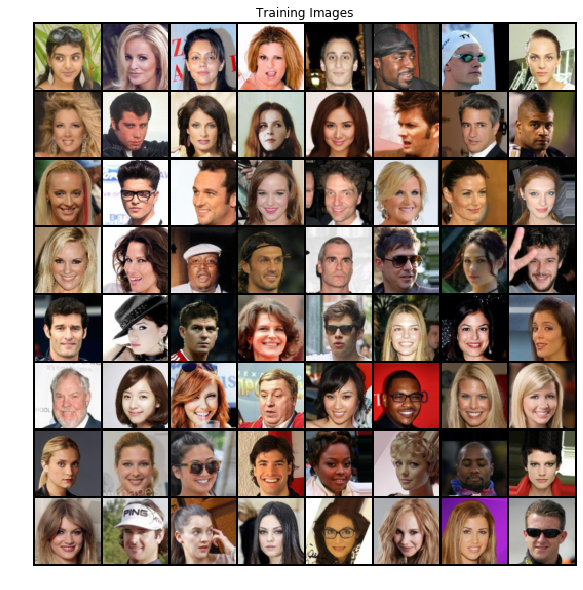

In [10]:
image_size = 64
batch_size = 64
workers = 4

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Random Sampling dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                         sampler=torch.utils.data.RandomSampler(dataset, 
                                                                                replacement=True,
                                                                                num_samples=2000*batch_size),
                                         shuffle=False,
                                         num_workers=workers)
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),
                        (1,2,0)))

In [12]:
real_batch[0].shape

torch.Size([64, 3, 64, 64])

In [13]:
# Root directory for dataset
dataroot = "~/datasets"

image_size = 28
batch_size = 128
workers = 4

dataset = dset.FashionMNIST(dataroot, train=True, 
                            transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]), 
                            
                            target_transform=None, download=True)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=torch.utils.data.RandomSampler(dataset, 
                                                                                replacement=True,
                                                                                num_samples=100*batch_size),
                                         shuffle=False, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
train_loader = dataloader

In [21]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch, log_interval = 10):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [23]:
ret = train(0)

Train Epoch: 0 [0/60000 (0%)]	Loss: 549.087952
Train Epoch: 0 [1280/60000 (2%)]	Loss: 415.168030
Train Epoch: 0 [2560/60000 (4%)]	Loss: 374.510345
Train Epoch: 0 [3840/60000 (6%)]	Loss: 358.906647
Train Epoch: 0 [5120/60000 (9%)]	Loss: 341.890839
Train Epoch: 0 [6400/60000 (11%)]	Loss: 326.539764
Train Epoch: 0 [7680/60000 (13%)]	Loss: 304.131683
Train Epoch: 0 [8960/60000 (15%)]	Loss: 310.234833
Train Epoch: 0 [10240/60000 (17%)]	Loss: 290.094452
Train Epoch: 0 [11520/60000 (19%)]	Loss: 306.347717
====> Epoch: 0 Average loss: 73.0484


In [25]:
for e in range(100):
    train(e)

Train Epoch: 0 [0/60000 (0%)]	Loss: 302.894714
Train Epoch: 0 [1280/60000 (2%)]	Loss: 280.415070
Train Epoch: 0 [2560/60000 (4%)]	Loss: 280.655121
Train Epoch: 0 [3840/60000 (6%)]	Loss: 282.875397
Train Epoch: 0 [5120/60000 (9%)]	Loss: 288.477539
Train Epoch: 0 [6400/60000 (11%)]	Loss: 279.608368
Train Epoch: 0 [7680/60000 (13%)]	Loss: 281.374298
Train Epoch: 0 [8960/60000 (15%)]	Loss: 273.329071
Train Epoch: 0 [10240/60000 (17%)]	Loss: 271.841003
Train Epoch: 0 [11520/60000 (19%)]	Loss: 272.231781
====> Epoch: 0 Average loss: 60.1449
Train Epoch: 1 [0/60000 (0%)]	Loss: 273.940369
Train Epoch: 1 [1280/60000 (2%)]	Loss: 269.371094
Train Epoch: 1 [2560/60000 (4%)]	Loss: 281.725037
Train Epoch: 1 [3840/60000 (6%)]	Loss: 269.762299
Train Epoch: 1 [5120/60000 (9%)]	Loss: 275.569489
Train Epoch: 1 [6400/60000 (11%)]	Loss: 267.155457
Train Epoch: 1 [7680/60000 (13%)]	Loss: 274.875977
Train Epoch: 1 [8960/60000 (15%)]	Loss: 270.618774
Train Epoch: 1 [10240/60000 (17%)]	Loss: 274.656464
Train E

Train Epoch: 15 [1280/60000 (2%)]	Loss: 231.203415
Train Epoch: 15 [2560/60000 (4%)]	Loss: 247.544128
Train Epoch: 15 [3840/60000 (6%)]	Loss: 248.746078
Train Epoch: 15 [5120/60000 (9%)]	Loss: 245.742752
Train Epoch: 15 [6400/60000 (11%)]	Loss: 249.890793
Train Epoch: 15 [7680/60000 (13%)]	Loss: 257.019012
Train Epoch: 15 [8960/60000 (15%)]	Loss: 247.120270
Train Epoch: 15 [10240/60000 (17%)]	Loss: 254.669571
Train Epoch: 15 [11520/60000 (19%)]	Loss: 246.048767
====> Epoch: 15 Average loss: 53.0764
Train Epoch: 16 [0/60000 (0%)]	Loss: 242.613983
Train Epoch: 16 [1280/60000 (2%)]	Loss: 248.641327
Train Epoch: 16 [2560/60000 (4%)]	Loss: 254.268127
Train Epoch: 16 [3840/60000 (6%)]	Loss: 261.834442
Train Epoch: 16 [5120/60000 (9%)]	Loss: 241.645554
Train Epoch: 16 [6400/60000 (11%)]	Loss: 248.143707
Train Epoch: 16 [7680/60000 (13%)]	Loss: 238.101120
Train Epoch: 16 [8960/60000 (15%)]	Loss: 247.290558
Train Epoch: 16 [10240/60000 (17%)]	Loss: 244.150421
Train Epoch: 16 [11520/60000 (19%)]

====> Epoch: 29 Average loss: 52.1488
Train Epoch: 30 [0/60000 (0%)]	Loss: 249.846542
Train Epoch: 30 [1280/60000 (2%)]	Loss: 248.357132
Train Epoch: 30 [2560/60000 (4%)]	Loss: 239.644867
Train Epoch: 30 [3840/60000 (6%)]	Loss: 239.830765
Train Epoch: 30 [5120/60000 (9%)]	Loss: 240.952072
Train Epoch: 30 [6400/60000 (11%)]	Loss: 239.517776
Train Epoch: 30 [7680/60000 (13%)]	Loss: 247.269928
Train Epoch: 30 [8960/60000 (15%)]	Loss: 241.472092
Train Epoch: 30 [10240/60000 (17%)]	Loss: 253.529037
Train Epoch: 30 [11520/60000 (19%)]	Loss: 247.404297
====> Epoch: 30 Average loss: 52.0269
Train Epoch: 31 [0/60000 (0%)]	Loss: 237.954910
Train Epoch: 31 [1280/60000 (2%)]	Loss: 245.445526
Train Epoch: 31 [2560/60000 (4%)]	Loss: 246.301193
Train Epoch: 31 [3840/60000 (6%)]	Loss: 259.967285
Train Epoch: 31 [5120/60000 (9%)]	Loss: 244.754318
Train Epoch: 31 [6400/60000 (11%)]	Loss: 229.441238
Train Epoch: 31 [7680/60000 (13%)]	Loss: 246.293121
Train Epoch: 31 [8960/60000 (15%)]	Loss: 263.787109
Tr

Train Epoch: 44 [11520/60000 (19%)]	Loss: 243.403061
====> Epoch: 44 Average loss: 51.6967
Train Epoch: 45 [0/60000 (0%)]	Loss: 247.001465
Train Epoch: 45 [1280/60000 (2%)]	Loss: 236.417191
Train Epoch: 45 [2560/60000 (4%)]	Loss: 240.836243
Train Epoch: 45 [3840/60000 (6%)]	Loss: 240.117218
Train Epoch: 45 [5120/60000 (9%)]	Loss: 243.174133
Train Epoch: 45 [6400/60000 (11%)]	Loss: 242.375183
Train Epoch: 45 [7680/60000 (13%)]	Loss: 242.397583
Train Epoch: 45 [8960/60000 (15%)]	Loss: 240.616684
Train Epoch: 45 [10240/60000 (17%)]	Loss: 243.038315
Train Epoch: 45 [11520/60000 (19%)]	Loss: 243.263458
====> Epoch: 45 Average loss: 51.7286
Train Epoch: 46 [0/60000 (0%)]	Loss: 242.912827
Train Epoch: 46 [1280/60000 (2%)]	Loss: 240.723053
Train Epoch: 46 [2560/60000 (4%)]	Loss: 250.527039
Train Epoch: 46 [3840/60000 (6%)]	Loss: 239.607788
Train Epoch: 46 [5120/60000 (9%)]	Loss: 244.794647
Train Epoch: 46 [6400/60000 (11%)]	Loss: 239.921875
Train Epoch: 46 [7680/60000 (13%)]	Loss: 243.770233
T

Train Epoch: 59 [10240/60000 (17%)]	Loss: 255.713593
Train Epoch: 59 [11520/60000 (19%)]	Loss: 237.960327
====> Epoch: 59 Average loss: 51.5545
Train Epoch: 60 [0/60000 (0%)]	Loss: 239.593597
Train Epoch: 60 [1280/60000 (2%)]	Loss: 256.914764
Train Epoch: 60 [2560/60000 (4%)]	Loss: 243.082840
Train Epoch: 60 [3840/60000 (6%)]	Loss: 248.307877
Train Epoch: 60 [5120/60000 (9%)]	Loss: 251.510986
Train Epoch: 60 [6400/60000 (11%)]	Loss: 228.279556
Train Epoch: 60 [7680/60000 (13%)]	Loss: 236.492950
Train Epoch: 60 [8960/60000 (15%)]	Loss: 235.270615
Train Epoch: 60 [10240/60000 (17%)]	Loss: 244.695374
Train Epoch: 60 [11520/60000 (19%)]	Loss: 243.787109
====> Epoch: 60 Average loss: 51.4970
Train Epoch: 61 [0/60000 (0%)]	Loss: 229.194702
Train Epoch: 61 [1280/60000 (2%)]	Loss: 251.286163
Train Epoch: 61 [2560/60000 (4%)]	Loss: 255.224304
Train Epoch: 61 [3840/60000 (6%)]	Loss: 234.034424
Train Epoch: 61 [5120/60000 (9%)]	Loss: 232.257217
Train Epoch: 61 [6400/60000 (11%)]	Loss: 232.677139


Train Epoch: 74 [8960/60000 (15%)]	Loss: 246.187729
Train Epoch: 74 [10240/60000 (17%)]	Loss: 236.967514
Train Epoch: 74 [11520/60000 (19%)]	Loss: 231.298157
====> Epoch: 74 Average loss: 51.4273
Train Epoch: 75 [0/60000 (0%)]	Loss: 239.150940
Train Epoch: 75 [1280/60000 (2%)]	Loss: 242.702072
Train Epoch: 75 [2560/60000 (4%)]	Loss: 230.755249
Train Epoch: 75 [3840/60000 (6%)]	Loss: 243.335251
Train Epoch: 75 [5120/60000 (9%)]	Loss: 239.894302
Train Epoch: 75 [6400/60000 (11%)]	Loss: 230.206909
Train Epoch: 75 [7680/60000 (13%)]	Loss: 250.975815
Train Epoch: 75 [8960/60000 (15%)]	Loss: 246.591568
Train Epoch: 75 [10240/60000 (17%)]	Loss: 232.594971
Train Epoch: 75 [11520/60000 (19%)]	Loss: 237.814072
====> Epoch: 75 Average loss: 51.1898
Train Epoch: 76 [0/60000 (0%)]	Loss: 234.431351
Train Epoch: 76 [1280/60000 (2%)]	Loss: 257.098022
Train Epoch: 76 [2560/60000 (4%)]	Loss: 238.131088
Train Epoch: 76 [3840/60000 (6%)]	Loss: 237.718567
Train Epoch: 76 [5120/60000 (9%)]	Loss: 249.450378


Train Epoch: 89 [7680/60000 (13%)]	Loss: 241.395493
Train Epoch: 89 [8960/60000 (15%)]	Loss: 249.818527
Train Epoch: 89 [10240/60000 (17%)]	Loss: 231.300354
Train Epoch: 89 [11520/60000 (19%)]	Loss: 242.025406
====> Epoch: 89 Average loss: 51.2453
Train Epoch: 90 [0/60000 (0%)]	Loss: 235.922684
Train Epoch: 90 [1280/60000 (2%)]	Loss: 236.782211
Train Epoch: 90 [2560/60000 (4%)]	Loss: 235.782837
Train Epoch: 90 [3840/60000 (6%)]	Loss: 230.625153
Train Epoch: 90 [5120/60000 (9%)]	Loss: 246.886108
Train Epoch: 90 [6400/60000 (11%)]	Loss: 241.906555
Train Epoch: 90 [7680/60000 (13%)]	Loss: 233.044922
Train Epoch: 90 [8960/60000 (15%)]	Loss: 239.392380
Train Epoch: 90 [10240/60000 (17%)]	Loss: 246.517700
Train Epoch: 90 [11520/60000 (19%)]	Loss: 247.792862
====> Epoch: 90 Average loss: 51.2677
Train Epoch: 91 [0/60000 (0%)]	Loss: 240.695023
Train Epoch: 91 [1280/60000 (2%)]	Loss: 228.943787
Train Epoch: 91 [2560/60000 (4%)]	Loss: 236.007889
Train Epoch: 91 [3840/60000 (6%)]	Loss: 244.272598

If i reparamaterize with a bag - does it only produce bags?

In [57]:
real_batch = next(iter(train_loader))

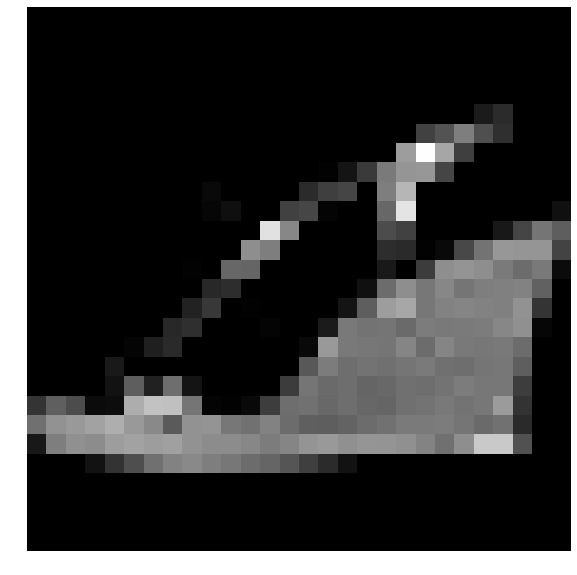

In [77]:
torch_gan.GANTrainer.grid_display(real_batch[0][98]);

In [54]:
z = torch.randn(1, 20)

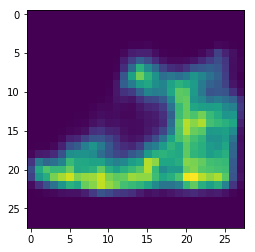

In [96]:
plt.imshow(model(real_batch[0][98])[0].reshape(28, 28).detach().numpy())

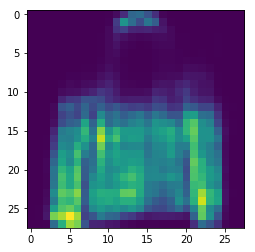

In [55]:

plt.imshow(model.decode(z).reshape(28, 28).detach().numpy())